# Belgian economic model

*Original code by Cyril Garneau. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

The economic model uses the latest economic data from Belgium to estimate the impact of the pandemic. We gratefuly acknowledge professors Gert Peersman and Koen Schoors for the data and sharing their expert knowledge with us. In this implementation, it is used in conjunction with our age-layered extended SEIR model. The economic model will, at a later stage of development, also be used in conjuction with a network model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import economic_model
from covid19model.models import models
from covid19model.models import economic_model
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Epidomological Model initialisation

To initiate the economic model we must first create a correct age-layered extended SEIR model using the `SEIRSAgeModel` object from the `models.py` script.

In [28]:
# Load interaction matrices
Nc_home = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELhome.txt", dtype='f', delimiter='\t')
Nc_work = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELwork.txt", dtype='f', delimiter='\t')
Nc_schools = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELschools.txt", dtype='f', delimiter='\t')
Nc_transport = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELtransport.txt", dtype='f', delimiter='\t')
Nc_leisure = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELleisure.txt", dtype='f', delimiter='\t')
Nc_others = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELothers.txt", dtype='f', delimiter='\t')
Nc_total = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELtotal.txt", dtype='f', delimiter='\t')
initN = np.loadtxt("../data/raw/Interaction_matrices/Belgium/BELagedist_10year.txt", dtype='f', delimiter='\t')

In [29]:
h = np.array([[0.0205,0.0205,0.1755,0.1755,0.2115,0.2503,0.3066,0.4033,0.4770]])
icu = np.array([0,0,0.0310,0.0310,0.055,0.077,0.107,0.1685,0.1895])
r = icu/h

In [112]:
epiModel = models.SEIRSAgeModel(initN   = initN,         #16x0 numpy array
                                     beta    = 0.0622, # probability of infection when encountering infected person
                                     sigma   = 3.2, # latent period
                                     omega   = 2.0, # pre-symptomatic infectious period
                                     Nc = Nc_total, #must be a numpy array; average number of human-to-human interactions per day
                                     a = 0.43, # probability of an asymptotic (supermild) infection
                                     m = 1-0.43, # probability of a mild infection
                                     h = h, # probability of hospitalisation for a mild infection
                                     c = 1-r, # probability of hospitalisation in cohort
                                     mi = 0.5*r, # probability of hospitalisation in midcare
                                     da = 7, # days of infection when asymptomatic (supermild)
                                     dm = 7, # days of infection when mild
                                     dc = 8,
                                     dmi = 8,
                                     dICU = 8,
                                     dICUrec = 7,
                                     dmirec = 7,
                                     dhospital = 4, # days before reaching the hospital when heavy or critical
                                     #m0 = np.transpose(np.array([0.000094,0.00022,0.00091,0.0018,0.004,0.013,0.046,0.098,0.18])), # mortality in ICU
                                     m0 = np.ones(9)*0.50,
                                     maxICU = 2000,
                                     totalTests = 0,
                                     psi_FP = 0, # probability of a false positive
                                     psi_PP = 1, # probability of a correct test
                                     dq = 14, # days in quarantaine                          
                                     initE = np.array([1,1,1,0,0,0,0,0,0]), #must be a numpy array
                                     initI = np.zeros(9),
                                     initA = np.zeros(9), 
                                     initM = np.zeros(9),
                                     initC = np.zeros(9),
                                     initCmirec = np.zeros(9),
                                     initCicurec = np.zeros(9),
                                     initMi = np.zeros(9),
                                     initICU = np.zeros(9),
                                     initR = np.zeros(9),
                                     initD = np.zeros(9),
                                     initSQ = np.zeros(9),
                                     initEQ = np.zeros(9),
                                     initIQ = np.zeros(9),
                                     initAQ = np.zeros(9),
                                     initMQ = np.zeros(9),
                                     initRQ = np.zeros(9),
                                     monteCarlo = False,
                                     n_samples = 1,
                            )

We can now initiate our economic model. The initialisation function requires as its sole input the epidemological model object. The 9x1 `initN` numpy array, which contains the total number of individuals in 5 year age bins, is used to compute the population of students (ages 20 or below), retired people (ages 60 or above), working people (ages 20-60) and the total population. Next, the economic model loads two sets of economic data from the following spreadsheets,
1. The Sectoral Data (`Sectoral_data.xlsx`) contains the value added and the employment by each economic sector of Belgium.
2. The `Staff distribution by sector.xlsx` is recent data (recieved on April 25th) covering 70% of Belgian workforce that provide the breakdown of people working from home, from their usual workplace, a mix of both or are temporarily unemployed or absent. This data is taken as the maximal impact from confinment measures.

Three dictionaries, assigned to the `self` attribute of the economic model, are used to hold these data,

```python
Inputs = 'Industry breakdown'      # Description of industry classes
         'Value Added'             # Economic value added by Belgian workers (per year)
         'Employment'              # Number of employees per industry
         'Value Added per Employe' # Value added per employee (per year)
         'Employment fraction'     # Ratio of employees in each industry with respect to total number of workers.

ReferenceNumbers = 'Population'         # Full population of Belgium
                   'Student population' # Population of "students", i.e. Belgians below 20.
                   'Retired population' # Population of "retired", i.e. Belgians above 65.
                   'Working population' # Population of "working" Belgian without pandemic.
                   'Non working population' # Population of "non working Belgians"

Adaptation = 'Work at home'             # Employees working from home
             'Mix home - office'        # Employees using a mix of work from home and at the workplace
             'Work at work'             # Employees working from their workplace
             'Temporary Unemployed'     # Employees temporarily unemployed
             'Absent'                   # Employees absent from work
             'Date of Survey'           # Date of the reception of the survey`
```

In [113]:
ecoModel = economic_model.EconomicModel(epiModel)

These data are stored in python dictionnaries and can be accessed from the model as below,

In [114]:
print('The stored population of Belgium is ' + str(int(ecoModel.ReferenceNumbers['Population'])) + ' inhabitants')

The stored population of Belgium is 11539326 inhabitants


## Run a simple simulation of the epidemological model

In [123]:
unconfined = [1, 1, np.ones(37), 1, 1]
lockdown = [0.3,0,np.zeros(37),0,0.1]

In [124]:
out=ecoModel.runMetaPopulationSimulation(120,lockdown,checkpoints=None)
VA,VA_total = ecoModel.calcAddedValue(out,confinement=True)

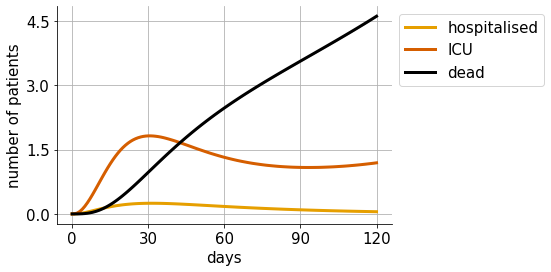

In [125]:
epiModel.plotInfected()

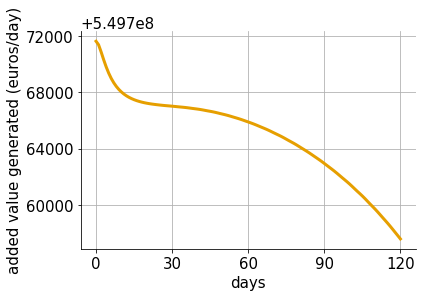

In [126]:
# Make a figure
fig, ax = plt.subplots()
ax.plot(np.linspace(0,120,121),np.transpose(VA_total))
ax.set_xlabel("days")
ax.set_ylabel("added value generated (euros/day)")
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# enable the grid
plt.grid(True)
# To specify the number of ticks on both or any single axes
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

In [127]:
addedValue_sector_conf,addedValue_total_conf = ecoModel.calcAddedValue(epiModel,confinement=True)
addedValue_sector_noConf,addedValue_total_noConf = ecoModel.calcAddedValue(epiModel,confinement=False)

plt.figure(1)
plt.plot(epiModel.tseries,addedValue_total_noConf-addedValue_total_conf)
plt.plot(epiModel.tseries,addedValue_total_noConf)
plt.plot(epiModel.tseries,addedValue_total_conf)
plt.legend(('difference','without confinement','with confinement'))

plt.figure(2)
plt.plot(epiModel.tseries,addedValue_total_conf)
plt.legend(('difference'))

TypeError: object of type 'SEIRSAgeModel' has no len()

## Building an economical model
The economic model assesses a large network of individuals from the SEIRS Network Model. Once each individual is assigned a health status, they can receive an economical status which is the combination of an `Occupation` and a `State`.
This status could be integrated to SEIRS Network but, at the moment, it is simply generated in a stand-alone 2D matrix. 

### Addind an occupation to a network of individuals
The network of individuals can be assigned to an occupation and a state.
The occupation will be any of the following, based on demographic data and 2018 employment census:
* [-2] Student (0-20 yo)
* [-1] Retired (70+ yo)
* [0] Non-working (active population that do not work or seek employment)
* [1 - 37] Working or work seeker in one of 37 economical sectors

The state of non-working population (students, retired or non-working) can be:
* [-1] Confined
* [0] Unconfined

And the state of working population can be:
* [1] Working from home
* [2] Mix of working from home and at work (office/factory/etc.)
* [3] Working at work (office/factory/etc.)
* [4] Temporarily unemployed
* [5] Absent

The function `AssignOccupation` returns a Status Matrix that assigns both an occupation and a state of work randomly, according to current data. Each line correspond to one individual. Column zero holds the `Occupation` and column 1 holds the `State`.

In [ ]:
PopulationMatrix = ecoModel.AssignOccupation(ecoModel,N = 2000, ConfinementPolicy = True)
print(PopulationMatrix[1:10,:])

Occupation information about the population can be extracted with the function `ComputeOccupation`. The number of confined, unconfined, working and unemployed individuals are returned. 

In [ ]:
print(EcoMod.ComputeOccupation(EcoMod,PopulationMatrix))

## Added Value
The `Added Value` gives an indication of the state of the economy. Industries need different amount of work to generate value, which is reflected in the added value. 
The function `ComputeValueAdded` computes the value added by the workers of a network by multiplying the `Value added by a Belgian worker` by the number of active workers in that specific industry. At the moment, no distinction is made wheter the work is performed at home or at the usual workplace.

In [ ]:
print("% 10.2f euros"% (EcoMod.ComputeValueAdded(EcoMod,PopulationMatrix))) 

## Altering the confinement policy
In order to assess different scenarios, it is possible to alter restrictions on selected sectors of the population with the function `ChangeConfinementPolicy`. 
A call to `ChangeConfinementPolicy allows to set non-working individuals (students, retired, non-workers) to Confined or Unconfined status or to set a specific economy sector to a new confinement policy, between [0 - 1]. A policy of 0 maximizes the work from home and unemployment while a policy of 1 sends everyone to work (office/factory/etc.). Any number in between offers a linear tradeof.

For example, lifting the confinement on children and students can be done as follow:

In [ ]:
PopulationMatrix = EcoMod.ChangeConfinementPolicy(EcoMod,PopulationMatrix,-2, 1)
print(EcoMod.ComputeOccupation(EcoMod,PopulationMatrix))

Then opening back all retails (economic sector number 19):

In [ ]:
PopulationMatrix = EcoMod.ChangeConfinementPolicy(EcoMod,PopulationMatrix,19, 1)
print(EcoMod.ComputeOccupation(EcoMod,PopulationMatrix))
print("% 10.2f euros"% (EcoMod.ComputeValueAdded(EcoMod,PopulationMatrix))) 

Therefore, by reopening the shops, the daily added value of the network increased by about 10% (numbers will differ due to the random initialization of the network).

## State of development of the Economic Model

The model is still very basic, with only two objective functions (`ComputeOccupation` and `ComputeValueadded`).

Input-Output tables are available in the DATA folder, but not loaded in the model. 

No modification to the SEIRS model has been made to couple it with the economic model. However, as of today (April 27th), the link can be made by adding two attributes to each individual in the SEIRS: Occupation and Status. 
